In [ ]:
# !pip install statsmodels=='0.13.2'

     |████████████████████████████████| 9.8 MB 13.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import statsmodels as sts
sts.__version__

'0.13.2'

### **Fontes de pesquisa:**
> **Google acadêmico**
- Bitcoin Price Prediction: An ARIMA Approach: https://arxiv.org/abs/1904.05315
- Avaliação de técnicas de aprendizado de máquina para previsão de cargas de trabalho aplicadas para otimizar o provisionamento de recursos em nuvens computacionais: http://tede2.pucrs.br/tede2/handle/tede/8797#preview-link0
- Previsão de demanda com o uso de modelos auto regressivos e clusterização de séries temporais: um estudo de caso de uma empresa de varejo: https://repositorio.ufsc.br/handle/123456789/218772

> **Kaggle**
- Another look at Forecasting(GridSearch+ARIMA): https://www.kaggle.com/sbongo/another-look-at-forecasting-gridsearch-arima

> **Artigos**
- Modelos de Predição | Otimização de Hiperparâmetros em Python: https://medium.com/turing-talks/modelos-de-predi%C3%A7%C3%A3o-otimiza%C3%A7%C3%A3o-de-hiperpar%C3%A2metros-em-python-3436fc55016e
- Otimizando os hiperparâmetros: https://medium.com/data-hackers/otimizando-os-hiperpar%C3%A2metros-621de5e9be37
- How to Grid Search ARIMA Model Hyperparameters with Python: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- Previsão de temperatura com modelo ARIMA em Python: https://ichi.pro/pt/previsao-de-temperatura-com-modelo-arima-em-python-73096807304019

In [2]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from pandas.core.frame import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
%matplotlib inline
sns.set_context("paper")
import itertools
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_vento = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# Removendo todos as virgulas do dataset
df_vento.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_vento.Data = pd.to_datetime(df_vento.Data)

# Tranformando a coluna "Data" em index
df_vento.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_vento.select_dtypes(object).columns
df_vento[c] = df_vento[c].apply(pd.to_numeric,errors='coerce')
df_vento.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [4]:
df_pld = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv')
# Removendo todos as virgulas do dataset
df_pld.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df_pld['inicio_semana'] = pd.to_datetime(df_pld['inicio_semana'])

# Tranformando a coluna "Data" em index
df_pld.set_index('inicio_semana', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df_pld.select_dtypes(object).columns
df_pld[c] = df_pld[c].apply(pd.to_numeric,errors='coerce')
df_pld.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


## Separaão dos dados - Treino e Teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [40]:
def plot_results(train, validation, predictions, steps, size, variable, ylabel, approach='Walk-Forward', compare=False, predictions2=0):
    fig = plt.subplots(figsize=(10,5))
    start, end = [len(train)-size, len(train)]
    plt.plot(train[start:end], label='Treino')
    plt.plot(validation, label='Validação')
    if compare:
        plt.plot(predictions, '--', label='Expanding Window')
        plt.plot(predictions2, '--', label='Sliding Window')
        plt.title('Previsão com {} passos a frente - {}'.format(steps, variable))
        rmse1 = np.sqrt(mean_squared_error(validation.values, predictions.values))
        rmse2 = np.sqrt(mean_squared_error(validation.values, predictions2.values))
        mae1 = mean_absolute_error(validation.values, predictions.values)
        mae2 = mean_absolute_error(validation.values, predictions2.values)
        mse1 = mean_squared_error(validation.values, predictions.values)
        mse2 = mean_squared_error(validation.values, predictions2.values)
        print("Expanding Window: RMSE={:.5f} || MAE={:.5f} || MSE={:.5f}\nSliding Window: RMSE={:.5f} || MAE={:.5f} || MSE={:.5f}".format(rmse1, mae1, mse1, rmse2, mae2, mse2))
    else:
        plt.plot(predictions, '--', label='Previsão')
        plt.title('Previsão de {} passos a frente  - {} ({})'.format(steps, variable, approach))
    plt.xlabel("Período observado")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    rmse = np.sqrt(mean_squared_error(validation.values, predictions.values))
    mae = mean_absolute_error(validation.values, predictions.values)
    mse = mean_squared_error(validation.values, predictions.values)
    if not compare:
        print("RMSE: {:.5f} || MAE: {:.5f} || MSE: {:.5f}".format(rmse, mae, mse))

## Validação Walk-Forward

Treinar e validar os modelos obtidos a partir dos métodos auto-arima e pesquisa em grade utilizando a técnica walk-forward com as abordagens expanding window e sliding window

In [7]:
train_vento, test_vento = split_dataset(df_vento.Velocidade, 0.75, False)

BASE DE TREINO:  3675
BASE DE TESTE:   1225


In [8]:
train_pld, test_pld = split_dataset(df_pld.preco_medio, 0.75, False)

BASE DE TREINO:  332
BASE DE TESTE:   111


In [9]:
# size = int(len(test_vento) - (len(test_vento)-5))
# test_ = test_vento[0:size]
# test_

### Expanding Window

In [9]:
from pandas.core.frame import DataFrame
def expanding_window(train, test, params, steps):

    size = int(len(test) - (len(test)-steps))
    test_ = test[0:size]

    history = [x for x in train]
    prediction = list()
    error_rmse = list()
    error_mse = list()
    error_mae = list()
    for t in range(len(test_)):
        real_value = []
        pred_value = []
        model = ARIMA(history, order=params).fit()
        predict_value = model.forecast()[0]

        # atribuição dos dados reais e preditos
        prediction.append(round(predict_value,2))
        history.append(test_[t])
        # calcula o erro
        real_value.append(test_[t])
        pred_value.append(predict_value)
        rmse = np.sqrt(mean_squared_error(real_value, pred_value))
        mse = mean_squared_error(real_value, pred_value)
        mae = mean_absolute_error(real_value, pred_value)
        error_rmse.append(rmse)
        error_mse.append(mse)
        error_mae.append(mae)
        print('Valor Real=%.3f, Valor Predito=%.3f, RMSE=%.6f' % (test[t], predict_value, rmse))
    test_ = DataFrame(test_)
    test_['predictions_wf'] = prediction
    test_['rmse'] = error_rmse
    test_['mse'] = error_mse
    test_['mae'] = error_mae
    print(test_)
    return test_

> **Velocidade do vento - Macau**

Figure(640x480)
Figure(640x480)


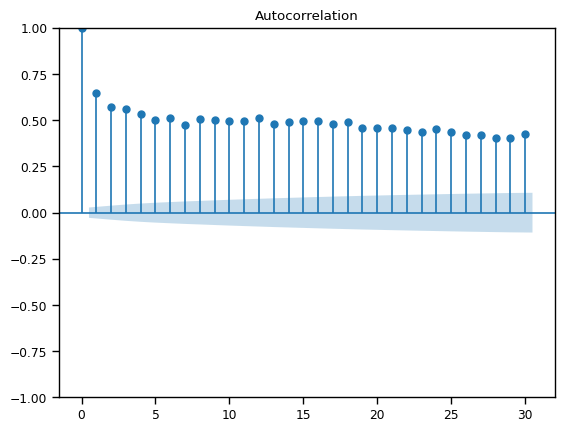

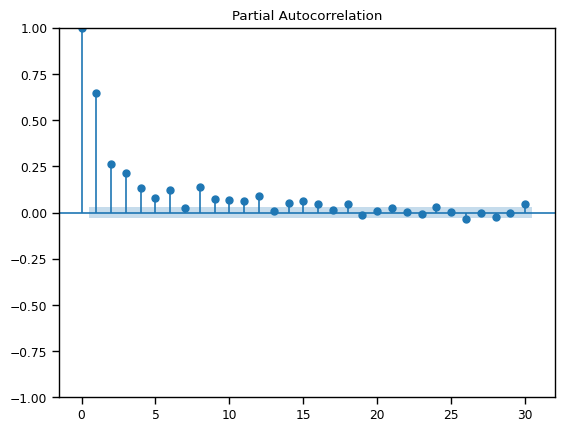

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print(plot_acf(df_vento['Velocidade'], lags=30))
print(plot_pacf(df_vento['Velocidade'], lags=30))

In [26]:
# 1 passo a frente
# vento1p_ew = expanding_window(train_vento, test_vento, (23,0,25), 1)
vento_ew = expanding_window(train_vento, test_vento, (6,0,0), 12)

#             Velocidade  predictions_wf
# Data
# 2014-01-23         7.1            6.47

Valor Real=7.100, Valor Predito=6.383, RMSE=0.716854
Valor Real=7.100, Valor Predito=6.315, RMSE=0.784836
Valor Real=7.630, Valor Predito=6.509, RMSE=1.120779
Valor Real=5.530, Valor Predito=6.960, RMSE=1.429991
Valor Real=6.700, Valor Predito=6.224, RMSE=0.476422
Valor Real=7.470, Valor Predito=6.598, RMSE=0.872195
Valor Real=6.270, Valor Predito=6.701, RMSE=0.430753
Valor Real=7.000, Valor Predito=6.457, RMSE=0.542511
Valor Real=5.500, Valor Predito=6.713, RMSE=1.213076
Valor Real=7.330, Valor Predito=5.924, RMSE=1.405609
Valor Real=8.470, Valor Predito=6.609, RMSE=1.861474
Valor Real=6.070, Valor Predito=7.108, RMSE=1.038329
            Velocidade  predictions_wf      rmse       mse       mae
Data                                                                
2014-01-23        7.10            6.38  0.716854  0.513880  0.716854
2014-01-24        7.10            6.32  0.784836  0.615967  0.784836
2014-01-25        7.63            6.51  1.120779  1.256145  1.120779
2014-01-26        5

In [25]:
real = [7.10, 7.10, 7.63]
prev = [6.40, 6.40, 6.40]
print(mean_squared_error(real,prev))
print(np.sqrt(mean_squared_error(real,prev)))
print(mean_absolute_error(real, prev))
print(mean_absolute_percentage_error(real,prev))

# MAE -> quando analisado individualmente, o erro é o mesmo do RMSE, porém, quando analisado o conjunto o erro difere
# RMSE -> Tira a raiz quadrada do erro médio quadrático, logo é a media do erro

0.8309666666666656
0.911573730790146
0.876666666666666
0.11946295510063432


In [45]:
# 12 passos a frente
vento12p_ew = expanding_window(train_vento, test_vento, (23,0,25), 12)

Valor Real=7.100, Valor Predito=6.679, RMSE=0.421074
Valor Real=7.100, Valor Predito=6.531, RMSE=0.569147
Valor Real=7.630, Valor Predito=6.728, RMSE=0.901689
Valor Real=5.530, Valor Predito=7.104, RMSE=1.574171
Valor Real=6.700, Valor Predito=6.055, RMSE=0.644963
Valor Real=7.470, Valor Predito=6.590, RMSE=0.880198
Valor Real=6.270, Valor Predito=6.506, RMSE=0.235965
Valor Real=7.000, Valor Predito=6.450, RMSE=0.549905
Valor Real=5.500, Valor Predito=6.859, RMSE=1.359448
Valor Real=7.330, Valor Predito=5.978, RMSE=1.351617
Valor Real=8.470, Valor Predito=6.560, RMSE=1.909702
Valor Real=6.070, Valor Predito=7.360, RMSE=1.290086
            Velocidade  predictions_wf      rmse       mse       mae
Data                                                                
2014-01-23        7.10            6.68  0.421074  0.177303  0.421074
2014-01-24        7.10            6.53  0.569147  0.323929  0.569147
2014-01-25        7.63            6.73  0.901689  0.813043  0.901689
2014-01-26        5

- Comparando os resultados - Velocidade do vento

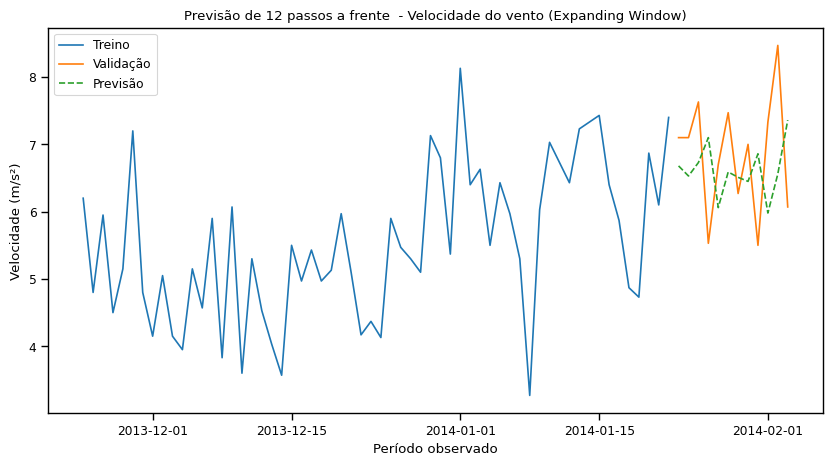

RMSE: 1.09181 || MAE: 0.97333 || MSE: 1.19205


In [46]:
plot_results(train_vento, vento12p_ew['Velocidade'], vento12p_ew['predictions_wf'], 12, 60, 'Velocidade do vento', 'Velocidade (m/s²)', approach='Expanding Window')

> **Preço médio - PLD Norte**

Figure(640x480)
Figure(640x480)


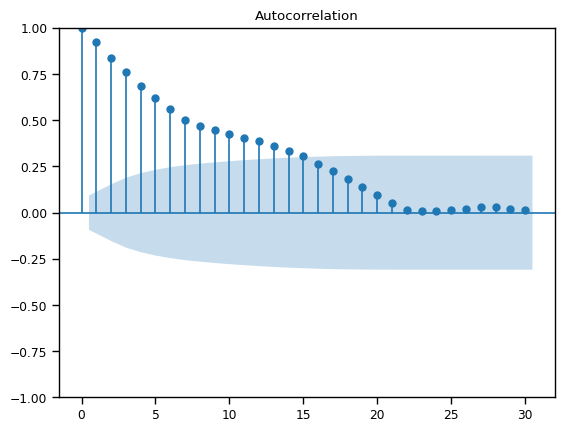

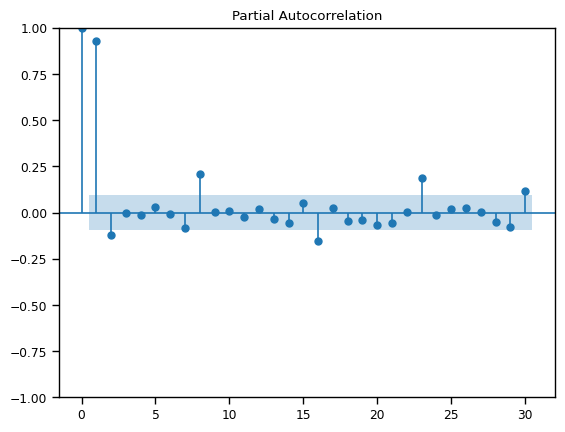

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print(plot_acf(df_pld['preco_medio'], lags=30))
print(plot_pacf(df_pld['preco_medio'], lags=30))

In [20]:
# 1 passo a frente
# pld1p_ew = expanding_window(train_pld, test_pld, (16,0,24), 1)

pld_ew = expanding_window(train_pld, test_pld, (1,0,0), 12)

Valor Real=181.300, Valor Predito=224.065, RMSE=42.765218
Valor Real=150.540, Valor Predito=181.673, RMSE=31.133476
Valor Real=169.650, Valor Predito=151.061, RMSE=18.589296
Valor Real=189.250, Valor Predito=170.078, RMSE=19.172028
Valor Real=212.200, Valor Predito=189.577, RMSE=22.623274
Valor Real=200.480, Valor Predito=212.419, RMSE=11.938511
Valor Real=199.760, Valor Predito=200.747, RMSE=0.986987
Valor Real=247.010, Valor Predito=200.043, RMSE=46.967052
Valor Real=473.300, Valor Predito=247.064, RMSE=226.235594
Valor Real=569.590, Valor Predito=472.344, RMSE=97.245666
Valor Real=569.590, Valor Predito=568.428, RMSE=1.162349
Valor Real=550.280, Valor Predito=568.445, RMSE=18.164950
               preco_medio  predictions_wf        rmse           mse  \
inicio_semana                                                          
2007-11-10          181.30          224.07   42.765218   1828.863898   
2007-11-17          150.54          181.67   31.133476    969.293343   
2007-11-24       

In [13]:
pld12p_ew = expanding_window(train_pld, test_pld, (16,0,24), 12)

Valor Real=181.300, Valor Predito=190.266, RMSE=8.965977
Valor Real=150.540, Valor Predito=169.713, RMSE=19.172559
Valor Real=169.650, Valor Predito=163.826, RMSE=5.823595
Valor Real=189.250, Valor Predito=162.761, RMSE=26.489418
Valor Real=212.200, Valor Predito=206.105, RMSE=6.095381
Valor Real=200.480, Valor Predito=215.232, RMSE=14.752323
Valor Real=199.760, Valor Predito=224.310, RMSE=24.550202
Valor Real=247.010, Valor Predito=219.840, RMSE=27.169868
Valor Real=473.300, Valor Predito=271.948, RMSE=201.351865
Valor Real=569.590, Valor Predito=463.055, RMSE=106.535363
Valor Real=569.590, Valor Predito=587.351, RMSE=17.760778
Valor Real=550.280, Valor Predito=605.085, RMSE=54.804815
               preco_medio  predictions_wf        rmse           mse  \
inicio_semana                                                          
2007-11-10          181.30          190.27    8.965977     80.388749   
2007-11-17          150.54          169.71   19.172559    367.587030   
2007-11-24       

> Comparação das previsões - PLD

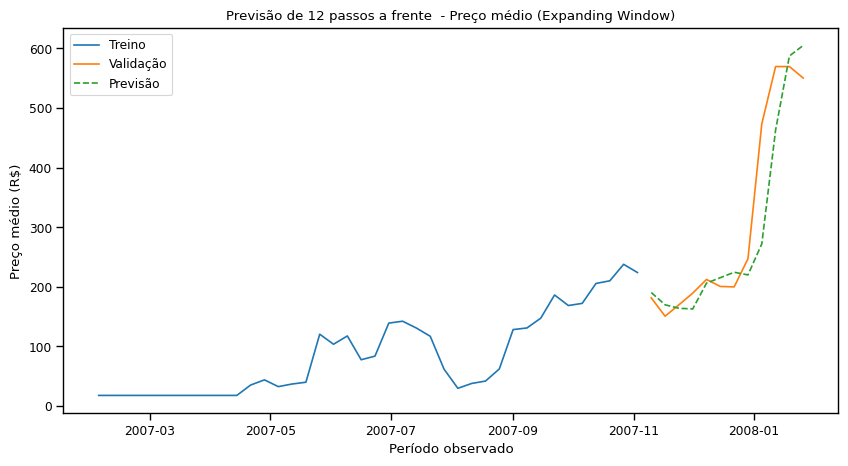

RMSE: 69.51635 || MAE: 42.78917 || MSE: 4832.52316


In [41]:
plot_results(train_pld, pld12p_ew['preco_medio'], pld12p_ew['predictions_wf'], 12, 40, 'Preço médio', 'Preço médio (R$)', approach='Expanding Window')

### Sliding Window

In [17]:
def sliding_window(train, test, params, steps):
    size = int(len(test) - (len(test)-steps))
    test_ = test[0:size]

    X = train.values
    window = len(X)
    # Obtem o primeiro valor da série
    history = [X[i] for i in range(window)]

    # Cria a lista de previsões
    prediction = list()
    error_rmse = list()
    error_mse = list()
    error_mae = list()
    for t in range(len(test_)):
        real_value = []
        pred_value = []
        length = len(history)

        # processo de janela deslizante
        history = [history[i] for i in range(length - window, length)]

        # ajuste do modelo
        model = ARIMA(history, order=params).fit()
        predict_value = model.forecast()[0]

        # atribuição dos valores
        prediction.append(predict_value)
        history.append(test_[t])
        # calcula o erro
        real_value.append(test_[t])
        pred_value.append(predict_value)
        rmse = np.sqrt(mean_squared_error(real_value, pred_value))
        mse = mean_squared_error(real_value, pred_value)
        mae = mean_absolute_error(real_value, pred_value)
        error_rmse.append(rmse)
        error_mse.append(mse)
        error_mae.append(mae)
        print('Valor Real=%.3f, Valor Predito=%.3f, RMSE=%.6f' % (test[t], predict_value, rmse))
    test_ = DataFrame(test_)
    test_['predictions_wf'] = prediction
    test_['rmse'] = error_rmse
    test_['mse'] = error_mse
    test_['mae'] = error_mae
    print("\n",test_)
    return test_

> **Velocidade do vento - Macau**

In [18]:
# 12 passo a frente
vento_sw = sliding_window(train_vento, test_vento, (6,0,0), 12)

Valor Real=7.100, Valor Predito=6.383, RMSE=0.716854
Valor Real=7.100, Valor Predito=6.315, RMSE=0.784973
Valor Real=7.630, Valor Predito=6.509, RMSE=1.120887
Valor Real=5.530, Valor Predito=6.962, RMSE=1.431809
Valor Real=6.700, Valor Predito=6.223, RMSE=0.476659
Valor Real=7.470, Valor Predito=6.596, RMSE=0.873884
Valor Real=6.270, Valor Predito=6.701, RMSE=0.430902
Valor Real=7.000, Valor Predito=6.460, RMSE=0.540011
Valor Real=5.500, Valor Predito=6.713, RMSE=1.213357
Valor Real=7.330, Valor Predito=5.922, RMSE=1.407580
Valor Real=8.470, Valor Predito=6.607, RMSE=1.863373
Valor Real=6.070, Valor Predito=7.109, RMSE=1.038955

             Velocidade  predictions_wf      rmse       mse       mae
Data                                                                
2014-01-23        7.10        6.383146  0.716854  0.513880  0.716854
2014-01-24        7.10        6.315027  0.784973  0.616183  0.784973
2014-01-25        7.63        6.509113  1.120887  1.256388  1.120887
2014-01-26       

In [47]:
# 12 passos a frente
vento12p_sw = sliding_window(train_vento, test_vento, (23,0,25), 12)

Valor Real=7.100, Valor Predito=6.679, RMSE=0.421074
Valor Real=7.100, Valor Predito=6.509, RMSE=0.590623
Valor Real=7.630, Valor Predito=6.698, RMSE=0.932436
Valor Real=5.530, Valor Predito=7.058, RMSE=1.527864
Valor Real=6.700, Valor Predito=6.041, RMSE=0.659467
Valor Real=7.470, Valor Predito=6.555, RMSE=0.915286
Valor Real=6.270, Valor Predito=6.468, RMSE=0.198066
Valor Real=7.000, Valor Predito=6.421, RMSE=0.578953
Valor Real=5.500, Valor Predito=6.865, RMSE=1.364818
Valor Real=7.330, Valor Predito=5.961, RMSE=1.368587
Valor Real=8.470, Valor Predito=6.566, RMSE=1.904376
Valor Real=6.070, Valor Predito=7.363, RMSE=1.292691

             Velocidade  predictions_wf      rmse       mse       mae
Data                                                                
2014-01-23        7.10        6.678926  0.421074  0.177303  0.421074
2014-01-24        7.10        6.509377  0.590623  0.348836  0.590623
2014-01-25        7.63        6.697564  0.932436  0.869436  0.932436
2014-01-26       

- Comparando os resultados - Velocidade do vento

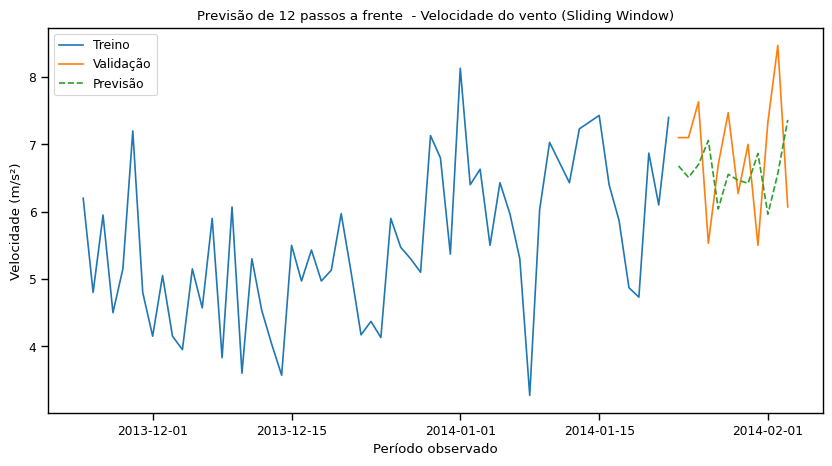

RMSE: 1.09584 || MAE: 0.97952 || MSE: 1.20087


In [49]:
plot_results(train_vento, vento12p_sw['Velocidade'], vento12p_sw['predictions_wf'], 12, 60, 'Velocidade do vento', 'Velocidade (m/s²)', approach='Sliding Window')

> **Preço médio - PLD Norte**

In [19]:
# 12 passo a frente
# pld1p_sw = sliding_window(train_pld, test_pld, (16,0,24), 1)
pld_sw = sliding_window(train_pld, test_pld, (1,0,0), 12)

Valor Real=181.300, Valor Predito=224.065, RMSE=42.765218
Valor Real=150.540, Valor Predito=181.654, RMSE=31.114261
Valor Real=169.650, Valor Predito=151.121, RMSE=18.528664
Valor Real=189.250, Valor Predito=170.050, RMSE=19.199834
Valor Real=212.200, Valor Predito=189.529, RMSE=22.670501
Valor Real=200.480, Valor Predito=212.373, RMSE=11.892740
Valor Real=199.760, Valor Predito=200.681, RMSE=0.921490
Valor Real=247.010, Valor Predito=197.647, RMSE=49.363042
Valor Real=473.300, Valor Predito=244.405, RMSE=228.895269
Valor Real=569.590, Valor Predito=470.185, RMSE=99.405429
Valor Real=569.590, Valor Predito=567.220, RMSE=2.370047
Valor Real=550.280, Valor Predito=567.255, RMSE=16.975467

                preco_medio  predictions_wf        rmse           mse  \
inicio_semana                                                          
2007-11-10          181.30      224.065218   42.765218   1828.863898   
2007-11-17          150.54      181.654261   31.114261    968.097229   
2007-11-24     

In [22]:
# 12 passo a frente
pld12p_sw = sliding_window(train_pld, test_pld, (16,0,24), 12)

Valor Real=181.300, Valor Predito=190.266, RMSE=8.965977
Valor Real=150.540, Valor Predito=141.677, RMSE=8.862876
Valor Real=169.650, Valor Predito=178.504, RMSE=8.854197
Valor Real=189.250, Valor Predito=170.262, RMSE=18.987541
Valor Real=212.200, Valor Predito=242.082, RMSE=29.882041
Valor Real=200.480, Valor Predito=245.242, RMSE=44.762417
Valor Real=199.760, Valor Predito=215.070, RMSE=15.309858
Valor Real=247.010, Valor Predito=192.373, RMSE=54.636852
Valor Real=473.300, Valor Predito=235.430, RMSE=237.870417
Valor Real=569.590, Valor Predito=527.495, RMSE=42.094872
Valor Real=569.590, Valor Predito=592.504, RMSE=22.914119
Valor Real=550.280, Valor Predito=596.705, RMSE=46.425092

                preco_medio  predictions_wf        rmse           mse  \
inicio_semana                                                          
2007-11-10          181.30      190.265977    8.965977     80.388749   
2007-11-17          150.54      141.677124    8.862876     78.550572   
2007-11-24      

> Comparação das previsões - PLD

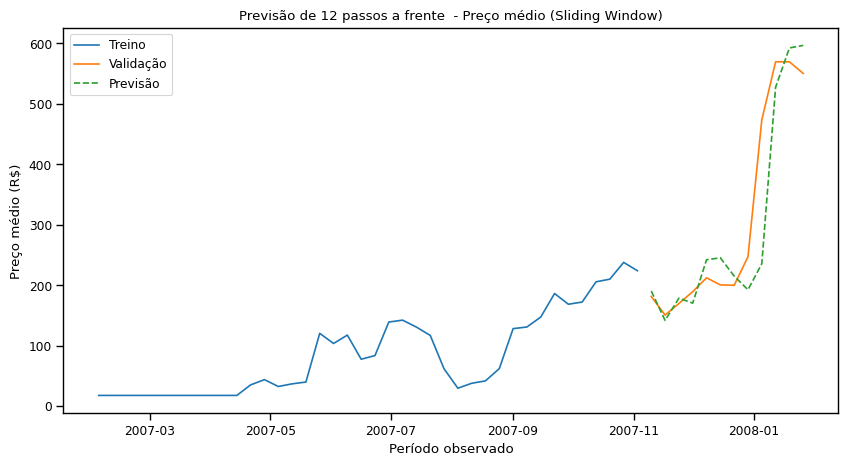

RMSE: 75.13805 || MAE: 44.96386 || MSE: 5645.72586


In [42]:
plot_results(train_pld, pld12p_sw['preco_medio'], pld12p_sw['predictions_wf'], 12, 40, 'Preço médio', 'Preço médio (R$)', approach='Sliding Window')

## Comparando as duas abordagens

Expanding Window: RMSE=1.09181 || MAE=0.97333 || MSE=1.19205
Sliding Window: RMSE=1.09584 || MAE=0.97952 || MSE=1.20087


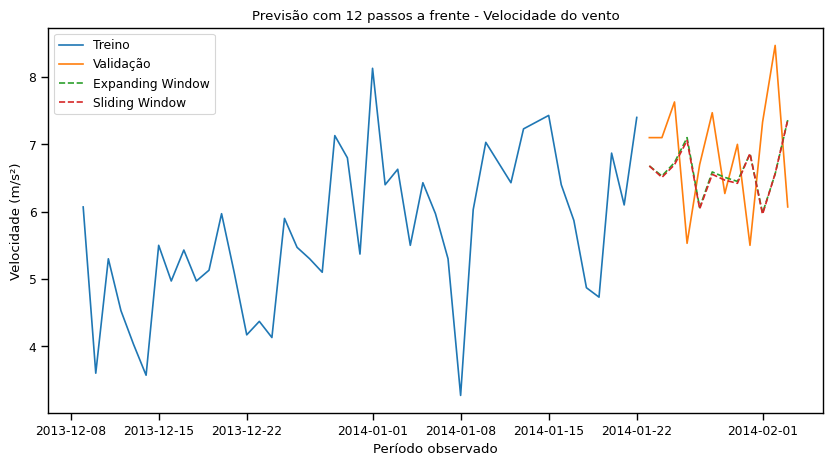

In [50]:
plot_results(train_vento, vento12p_ew['Velocidade'], vento12p_ew['predictions_wf'], 12, 45, 'Velocidade do vento', 'Velocidade (m/s²)', compare=True, predictions2=vento12p_sw['predictions_wf'])

Expanding Window: RMSE=69.51635 || MAE=42.78917 || MSE=4832.52316
Sliding Window: RMSE=75.13805 || MAE=44.96386 || MSE=5645.72586


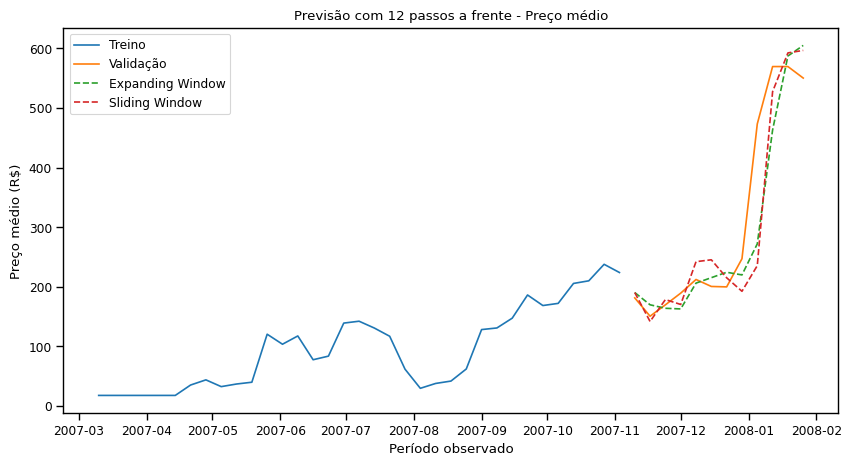

In [43]:
plot_results(train_pld, pld12p_ew['preco_medio'], pld12p_ew['predictions_wf'], 12, 35, 'Preço médio', 'Preço médio (R$)', compare=True, predictions2=pld12p_sw['predictions_wf'])